# CSCI 490 - Computer Vision 
# BIOMI 813 - Pattern recognition and machine learning
---
## Deep learning: Learning features
## a.k.a. The models of yesterday with the tools of tomorrow, today!

In [4]:
import os
import sys
import time
import struct
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import theano
import theano.tensor as T

import lasagne
import lasagne.layers as L
import lasagne.regularization as R
import lasagne.nonlinearities as NL
import lasagne.objectives as O
import lasagne.init as I

fpX = np.float32
from loadMNIST import LoadMNIST

# Basic Theano structures
### 1) Create symbols that we need

In [75]:
_X = T.matrix()
_Y = T.matrix()
_W = T.matrix()

### 2) Define the operations that we want performed

In [76]:
_H = T.dot(_W, _Y)
_Z = _X + _H
_L = T.sum(T.sqr(_Z)) # a loss function, any scalar made up of the input variables
_dLdW = T.grad(_L, wrt=_W) # a gradient expression: The gradient of _L with respect to _W

### 3) Compile our expression

In [77]:
Z_func = theano.function([_X, _Y, _W], _Z)
H_func = theano.function([_Y, _W], _H)
dLdW_func = theano.function([_X, _Y, _W], _dLdW)

### 4) Get some real data

In [78]:
X = np.random.normal(size=(100,100)).astype(fpX)
Y = np.random.normal(size=(500,100)).astype(fpX)
W = np.random.normal(size=(100,500)).astype(fpX)

### 5) Use our functions

In [79]:
Z_th = Z_func(X,Y,W)
H_th = H_func(Y, W)
dLdW_th = dLdW_func(X, Y, W)

### 6) Use our output to do other stuff

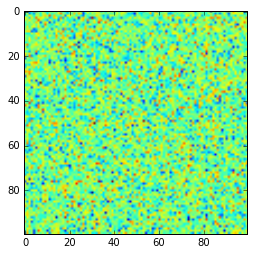

In [35]:
plt.imshow(Z_th)

# Procedure:
### Each example follow the simple following procedure:
### 0) Load the input example and target labels.

### 1) Define the network structure (i.e. select a model family).
We are only going to make modifications here. The network itself can be seen as a parametrized function $\bar y = f(x; \theta)$ where $x$ is the input, $\theta$ is the parameters and $\bar y$ is the predicted output. $y$ would be the target associated with $x$ i.e. the actual desired output.

### 2) Compile the gradient expression (i.e. select a loss function and learning procedure).
In theano (the machine learning framework used under the hood here), an expression is first created symbolically like a blueprint, then sent to the shop for manufacturing (compilation). Only after compilation do we have expression that we can use (e.g. $\bar y = f(x)$ or $\nabla_\theta E(x, y)$. 

### 3) Perform the parameter optimization (training).
Training is divided into epochs. One epoch means that we go through the whole set of training example once, and for each example we calculate the gradient of the loss with respect to the parameters of the network in order to improve (reduce) the loss. It is customary (though not required) to test the validation accuracy after each epoch of training.

### 4) Validate the newly parametrized network on new input/target pair 
Alternativelly this can be done during training to see how the validation accuracy change over time).

### 5) Look at the results

# Step 0) Load MNIST digits dataset

In [43]:
dataset_folder = os.getcwd() + '/' #'/home/styvesg/Documents/PostDoc/Programs/JupyterNotebooks/DataSet/'

mnist_trn_img = dataset_folder + 'train-images-idx3-ubyte'
mnist_trn_lab = dataset_folder + 'train-labels-idx1-ubyte'
mnist_val_img = dataset_folder + 't10k-images-idx3-ubyte'
mnist_val_lab = dataset_folder + 't10k-labels-idx1-ubyte'

print dataset_folder

/home/workstation3/notebooks/BIOMI813/


In [44]:
#Note that we reshaped the file into a 4d tensor with dimensions (sample_count, depth=1, x=28, y=28)
mnist_trn_data = LoadMNIST(mnist_trn_img).astype(fpX)[:,np.newaxis,:,:]
mnist_val_data = LoadMNIST(mnist_val_img).astype(fpX)[:,np.newaxis,:,:]
mnist_trn_label = LoadMNIST(mnist_trn_lab)
mnist_val_label = LoadMNIST(mnist_val_lab)

>u1
(60000, 28, 28)
>u1
(10000, 28, 28)
>u1
(60000,)
>u1
(10000,)


In [45]:
target_one = 1
target_zero = 0

trn_ones = mnist_trn_data[mnist_trn_label==target_one].astype('float32')
val_ones = mnist_val_data[mnist_val_label==target_one].astype('float32')

trn_zeros = mnist_trn_data[mnist_trn_label==target_zero].astype('float32')
val_zeros = mnist_val_data[mnist_val_label==target_zero].astype('float32')

there are 6742 ones and 5923 zeros in the training set
there are 1135 ones and 980 zeros in the validation set


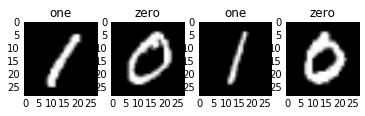

In [46]:
##sanity check
plt.subplot(1,4,1)
plt.imshow(trn_ones[0,0],cmap='gray')
plt.title('one')
plt.subplot(1,4,2)
plt.imshow(trn_zeros[0,0],cmap='gray')
plt.title('zero')
plt.subplot(1,4,3)
plt.imshow(val_ones[0,0],cmap='gray')
plt.title('one')
plt.subplot(1,4,4)
plt.imshow(val_zeros[0,0],cmap='gray')
plt.title('zero')

pixel_res = trn_ones.shape[2]
n_trn_ones = trn_ones.shape[0]
n_val_ones = val_ones.shape[0]
n_trn_zeros = trn_zeros.shape[0]
n_val_zeros = val_zeros.shape[0]

print 'there are %d ones and %d zeros in the training set' %(n_trn_ones,n_trn_zeros)
print 'there are %d ones and %d zeros in the validation set' %(n_val_ones,n_val_zeros)

In [48]:
##normalize images
##note the use of np.newaxis to take advantage of broadcasting rules!
for arr in [trn_ones, trn_zeros, val_ones, val_zeros]:
    arr -= np.mean(arr,axis=(2,3))[:,np.newaxis,np.newaxis]  
    arr /= np.sqrt(np.sum(arr**2,axis=(2,3)))[:,np.newaxis,np.newaxis]

# The old feature space

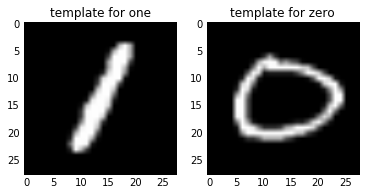

In [49]:
one_temp_idx = np.random.randint(0,high=n_trn_ones)    ##random template selection
zero_temp_idx = np.random.randint(0,high=n_trn_zeros)
one_temp = trn_ones[one_temp_idx,0]
zero_temp = trn_zeros[zero_temp_idx,0]

##view your templates
plt.subplot(1,2,1)
plt.imshow(one_temp,cmap='gray')
plt.title('template for one')
plt.subplot(1,2,2)
plt.imshow(zero_temp,cmap='gray')
plt.title('template for zero')

In [50]:
##first, we reshape the templates and stack them into a matrix
temps = np.array([zero_temp.ravel() , one_temp.ravel()]).T
print temps.shape

##next we project each of the images onto the templates
phi_s_ones = trn_ones.reshape((n_trn_ones,pixel_res**2)).dot(temps)
print phi_s_ones.shape

phi_s_zeros = trn_zeros.reshape((n_trn_zeros,pixel_res**2)).dot(temps)
print phi_s_zeros.shape

(784, 2)
(6742, 2)
(5923, 2)


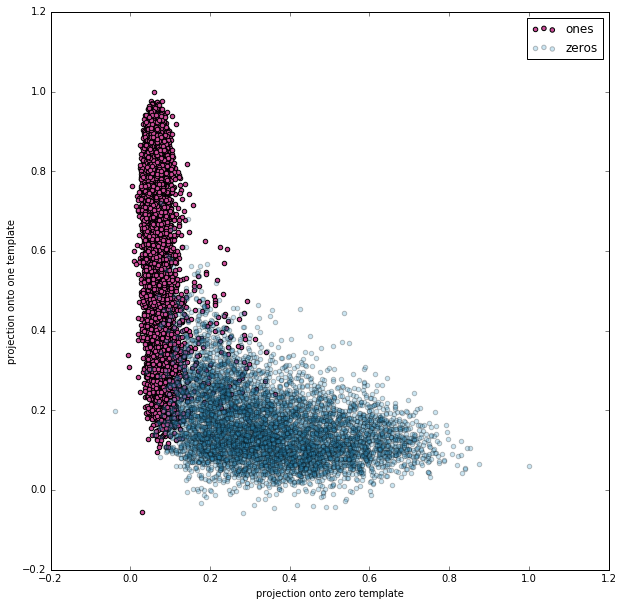

In [51]:
##view the projections, assigning different colors to each class
one_color = np.array([.8,.3,.6])  ##pink vector
zero_color = np.array([.2,.6,.8])  ##blue vector

plt.figure(figsize=(10,10))
plt.scatter(phi_s_ones[:,0], phi_s_ones[:,1],c=one_color,label='ones', alpha = 1)
plt.scatter(phi_s_zeros[:,0], phi_s_zeros[:,1],c=zero_color,label='zeros', alpha = 0.25)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('projection onto zero template')
plt.ylabel('projection onto one template')

### Some helpful functions

In [52]:
def print_lasagne_net(_net, skipnoparam=True):
    '''
    Print a summary of the layer and their parameter shapes
    '''
    layers = L.get_all_layers(_net)
    for l in layers:
        out = l.output_shape
        par = l.get_params()
        if skipnoparam and len(par)==0 and l.name==None:
            continue
        print "Layer\t: %s\nName\t: %s\nType\t: %s" % (l, l.name, type(l))
        print "Shape\t: %s" % (out,)
        if len(par)>0:
            print "Params"
            for p in par:
                print "        |-- {:<10}: {:}".format(p.name, p.get_value().shape,)
        print "\n"

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    '''
    for a given 4d input image tensor and a 2d target tensor of one-hot embedding, 
    return a shuffled batch of input-target pair
    '''
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]
          
def embedding(x, c=10): 
    '''
    Also known as one-hot embedding.
    '''
    y = np.zeros((len(x), c), dtype=fpX)
    y[np.arange(len(x)), x] = 1
    return y

# Step 1) Define the network structure (i.e. select a model family).

In [53]:
npc = 1         # # of channels in image
npx = 28        # # of pixels width/height of images
ny = 2          # # of classes

### Operation performed by DenseLayer():

DenseLayer, also known as fully connected layer, is just our standard linear (affine) transformation $Y = XW + b$ when there are no nonlinearity. The nonlinearity is applied elementwise after the affine transformation such that $Y = f(XW+b)$. If X has more than 2 dimension initially, e.g. [batch, input_feature, x, y], it will be flattened to 2 dimensions of size [batch, input_feature * x * y]. The output layer Y will be a 2-dimensional tensor of shape [batch, output_features]. Therefore, W must be of shape [input_feature, output_feature] and b is a vector of shape [output_feature] broadcasted along the batch dimension.

In [55]:
def model_1(__X):
    '''
    A single linear layer
    '''
    _input = L.InputLayer((None, npc, npx, npx), input_var=__X, name='X')
    _fc1 = L.DenseLayer(_input, ny, W=I.Normal(0.001), b=I.Constant(0.), nonlinearity=None) 
    return _fc1

In [56]:
_X = T.tensor4() # a theano variable representing the input data
_Y = T.matrix()  # a theano variable representing the class label

_cls = model_1(_X)

# Look at the details of the network input, output and filter shapes
print_lasagne_net(_cls, skipnoparam=True)

cls_params = L.get_all_params(_cls, trainable=True)
print cls_params

Layer	: <lasagne.layers.input.InputLayer object at 0x7f80cc77d250>
Name	: X
Type	: <class 'lasagne.layers.input.InputLayer'>
Shape	: (None, 1, 28, 28)


Layer	: <lasagne.layers.dense.DenseLayer object at 0x7f80cc6cf3d0>
Name	: None
Type	: <class 'lasagne.layers.dense.DenseLayer'>
Shape	: (None, 2)
Params
        |-- W         : (784, 2)
        |-- b         : (2,)


[W, b]


# Step 2) Compile the gradient expression 
## Define the loss function

The loss function is $L = \sum(\bar y - y)^2$.

In [57]:
def loss(__y_bar, __y):
    '''The loss function used to train the network -- tells what is good and what is bad'''
    return O.squared_error(__y_bar, __y).mean()

## compile the theano expressions, which involves selected an optimization procedure. 
Here, we use stochastic gradient descent (SGD). Stochastic gradient descent is exactly like normal gradient descent except that the gradient is calculated on a fraction of the whole dataset each iteration (what is called a batch). The result is that this gradient is not the exactly gradient but generally close to it. Therefore it has some randomness to it, which is why the method is called stochastic.

In [58]:
_lr = theano.shared(fpX(0))
_l2 = theano.shared(fpX(0))

_cls_reg = _l2 * R.regularize_layer_params(_cls, R.l2) # regularization loss
_cls_trn_pred = L.get_output(_cls, deterministic=False) # training prediction
_cls_trn_loss = loss(_cls_trn_pred, _Y) + _cls_reg # total training loss
_cls_trn_acc = T.mean(T.eq(T.argmax(_cls_trn_pred, axis=1), T.argmax(_Y, axis=1)), dtype=theano.config.floatX) # validation accuracies

_cls_val_pred = L.get_output(_cls, deterministic=True) #validation prediction
_cls_val_loss = loss(_cls_val_pred, _Y) + _cls_reg # total validation loss
_cls_val_acc = T.mean(T.eq(T.argmax(_cls_val_pred, axis=1), T.argmax(_Y, axis=1)), dtype=theano.config.floatX) # validation accuracies

_class = T.argmax(_cls_val_pred, axis=1)

cls_updates = lasagne.updates.sgd(_cls_trn_loss, cls_params, learning_rate=_lr) 

print 'COMPILING'
t = time.time()
cls_trn_fn = theano.function([_X, _Y], [_cls_trn_loss, _cls_trn_acc], updates=cls_updates)
cls_val_fn = theano.function([_X, _Y], [_cls_val_loss, _cls_val_acc])
cls_pred_fn = theano.function([_X], _cls_val_pred)
cls_class_fn = theano.function([_X], _class)
print '%.2f seconds to compile theano functions'%(time.time()-t)

COMPILING
3.52 seconds to compile theano functions


### The previous block of code compiles our training expressions. The important part are the functions that results:
cls_trn_fn(X, Y): The classifier training function. It takes a batch of sample data point and labels as input and performs gradient descent on the parameters (all of them!) of our network. It returns the loss and accuracy on that batch.

cls_val_fn(X, Y): The classifier validation function. It takes a batch of sample data point and labels as input and returns the loss and accuracy on that batch.

cls_pred_fn(X): For a batch of sample data point, return the predicted label i.e. the one corresponding to the maximum network output value.

### Reloading a trained model parameters (optional)

In [17]:
# Uncomment to reload values from file

# #cls_param_file = open(params_dir + cls_filename, 'rb')
# #cls_param_value = pickle.load(cls_param_file)
# #cls_param_file.close()
# #L.set_all_param_values(_cls, cls_param_value)  

# Step 3 & 4) Training and validating the model. 

-Note that the parameter initialization, which is very important for training success, was defined when we defined the network and the values were initialized at compilation time.

-We decrease learning rate by 'perc_decay'% every epoch after 'niter' epoch at initial rate 'lr'. This is to "fine tune" the learning process toward the end, and is known as learning rate decay.

-We record the history of the training and validation accuracies.

In [59]:
trn_data = np.concatenate([trn_ones, trn_zeros], axis=0).astype(fpX)
trn_label = np.concatenate([np.repeat([[0,1]], repeats=len(trn_ones), axis=0), np.repeat([[1,0]], repeats=len(trn_zeros), axis=0)], axis=0).astype(fpX)
val_data = np.concatenate([val_ones, val_zeros], axis=0).astype(fpX)
val_label =  np.concatenate([np.repeat([[0,1]], repeats=len(val_ones), axis=0), np.repeat([[1,0]], repeats=len(val_zeros), axis=0)], axis=0).astype(fpX)
print trn_data.shape
print trn_label.shape

(12665, 1, 28, 28)
(12665, 2)


In [60]:
lr = 1e-1   # initial learning rate for sgd
l2 = 0.    # l2 weight decay
niter = 20        # # of iter at starting learning rate
perc_decay = 5.0 # # of iter to linearly decay learning rate to zero
num_epochs = 10
batch_size = 200

_lr.set_value(fpX(lr))
_l2.set_value(fpX(l2))

trn_hist = []
val_hist = []

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    trn_err = 0
    trn_acc = 0
    trn_batches = 0
    start_time = time.time()
    for xb, yb in tqdm(iterate_minibatches(trn_data, trn_label, batch_size, shuffle=True)):
        _, _ = cls_trn_fn(xb, yb)
    
    for xb, yb in iterate_minibatches(trn_data, trn_label, batch_size, shuffle=False):
        err, acc = cls_val_fn(xb, yb)
        trn_err += err
        trn_acc += acc
        trn_batches += 1
    # And a full pass over the validation data:
    val_err = 0
    val_acc = 0
    val_batches = 0
    for xb, yb in iterate_minibatches(val_data, val_label, batch_size, shuffle=False):
        err, acc = cls_val_fn(xb, yb)
        val_err += err
        val_acc += acc
        val_batches += 1

    trn_hist += [trn_acc / trn_batches,]
    val_hist += [val_acc / val_batches,]
    # Then we print the results for this epoch:
    print("\n  Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss:       {:.6f}".format(trn_err / trn_batches))
    print("  training accuracy:   {:.2f} %".format(trn_acc / trn_batches * 100))
    print("  validation loss:     {:.6f}".format(val_err / val_batches))
    print("  validation accuracy: {:.2f} %".format(val_acc / val_batches * 100))
    
    if epoch > niter:
        _lr.set_value(fpX(_lr.get_value() * (1.0 - perc_decay / 100.0)))     
    sys.stdout.flush()

63it [00:00, 1241.38it/s]


  Epoch 1 of 10 took 0.090s
  training loss:       0.036013
  training accuracy:   99.61 %
  validation loss:     0.032036
  validation accuracy: 99.90 %



63it [00:00, 1378.68it/s]


  Epoch 2 of 10 took 0.078s
  training loss:       0.015573
  training accuracy:   99.64 %
  validation loss:     0.012177
  validation accuracy: 99.90 %



63it [00:00, 1354.44it/s]



  Epoch 3 of 10 took 0.087s
  training loss:       0.012512
  training accuracy:   99.68 %
  validation loss:     0.009504
  validation accuracy: 99.90 %


63it [00:00, 1391.89it/s]


  Epoch 4 of 10 took 0.077s
  training loss:       0.011315
  training accuracy:   99.72 %
  validation loss:     0.008559
  validation accuracy: 99.90 %



63it [00:00, 1382.01it/s]


  Epoch 5 of 10 took 0.078s
  training loss:       0.010524
  training accuracy:   99.75 %
  validation loss:     0.007871
  validation accuracy: 99.90 %



63it [00:00, 1367.07it/s]


  Epoch 6 of 10 took 0.078s
  training loss:       0.009915
  training accuracy:   99.75 %
  validation loss:     0.007399
  validation accuracy: 99.90 %



63it [00:00, 1378.22it/s]


  Epoch 7 of 10 took 0.077s
  training loss:       0.009450
  training accuracy:   99.75 %
  validation loss:     0.007024
  validation accuracy: 99.90 %



63it [00:00, 1369.18it/s]


  Epoch 8 of 10 took 0.078s
  training loss:       0.009079
  training accuracy:   99.75 %
  validation loss:     0.006719
  validation accuracy: 99.95 %



63it [00:00, 1386.39it/s]


  Epoch 9 of 10 took 0.077s
  training loss:       0.008777
  training accuracy:   99.76 %
  validation loss:     0.006481
  validation accuracy: 99.95 %



63it [00:00, 1368.88it/s]


  Epoch 10 of 10 took 0.078s
  training loss:       0.008523
  training accuracy:   99.76 %
  validation loss:     0.006296
  validation accuracy: 99.95 %


# 5) Look at the results

## Plot the history of training and validation accuracies

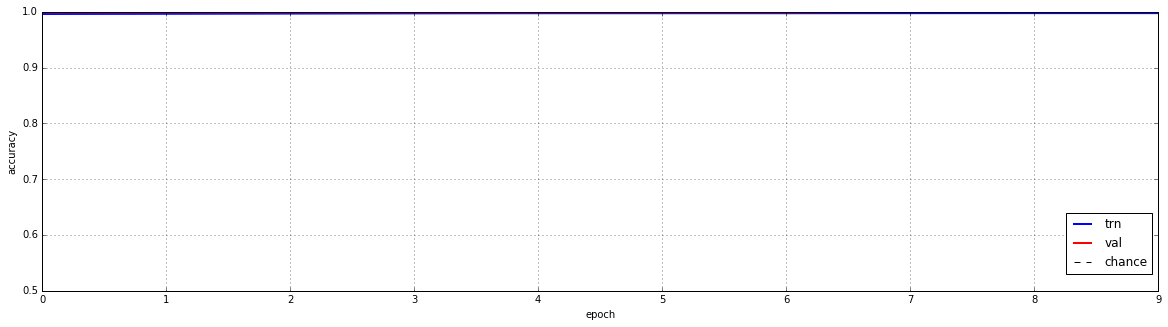

In [61]:
plt.figure(figsize=(20,5))
plt.plot(trn_hist, 'b', label='trn', lw=2)
plt.plot(val_hist, 'r', label='val', lw=2)
plt.axhline(1./ny, color='k', linestyle='--', label='chance')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0.5, 1.0)
plt.legend(bbox_to_anchor=(1., 0.3))
plt.grid()

## Display the learned weights (which used to be the examplars)
Make sure you understand that the weight that we optimized here are play a role analogous to the examplars used to go from image space to feature space times the previous optimal weights. Assume the 2 examplar are denoted as a 2-dimension tensor $\Phi$ of dimension $[n_x*n_y, 2]$ where $n_x$ and $n_y$ are the dimension of the image in pixel. The first column of $\Phi$ is the examplar for zeros $\phi_0$ while the second column is the examplar for ones $\phi_1$. So let's look at the "examplars" that we got from optimization (instead of picking them at random).

In [62]:
# get the parameter values into numpy array
W, b = [p.get_value() for p in cls_params]
print W.shape

(784, 2)


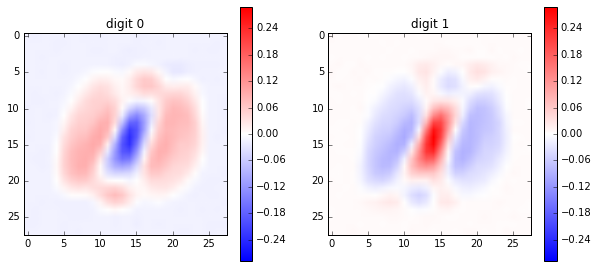

In [63]:
n = 2
x, y = 2, n//2 + 1
fig = plt.figure(figsize=(5*x,5*y))
cmax = np.max(np.abs(W))
for k in range(n):
    plt.subplot(x,y,k+1)
    plt.imshow(W.reshape(28,28,2)[:,:,k], cmap='bwr')
    plt.clim([-cmax, cmax])
    plt.title('digit %d' % k)
    plt.colorbar()

In [64]:
##next we project each of the images onto the templates
#phi_s_ones = trn_ones.reshape((n_trn_ones,pixel_res**2)).dot(W) + b
#print phi_s_ones.shape

#phi_s_zeros = trn_zeros.reshape((n_trn_zeros,pixel_res**2)).dot(W) + b
#print phi_s_zeros.shape#

phi_s_ones = cls_pred_fn(trn_ones)
phi_s_zeros = cls_pred_fn(trn_zeros)

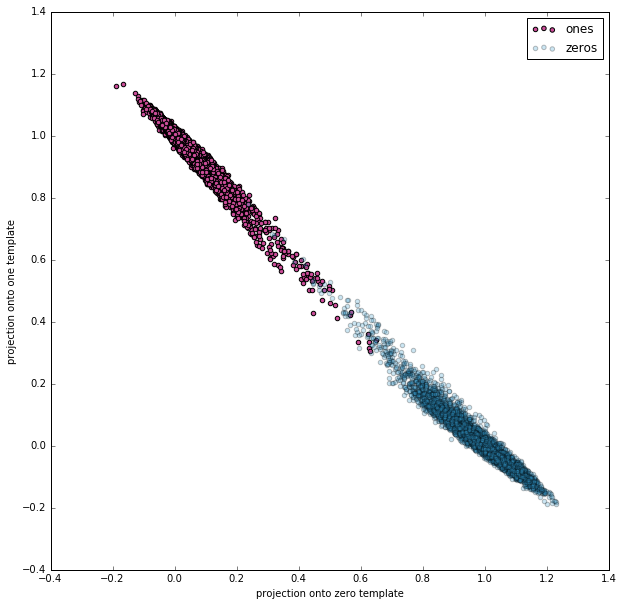

In [65]:
##view the projections, assigning different colors to each class
one_color = np.array([.8,.3,.6])  ##pink vector
zero_color = np.array([.2,.6,.8])  ##blue vector

plt.figure(figsize=(10,10))
plt.scatter(phi_s_ones[:,0], phi_s_ones[:,1],c=one_color,label='ones', alpha = 1)
plt.scatter(phi_s_zeros[:,0], phi_s_zeros[:,1],c=zero_color,label='zeros', alpha = 0.25)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('projection onto zero template')
plt.ylabel('projection onto one template')